In [1]:
import ctypes
import matplotlib.pyplot as plt
import numpy as np

from ctypes import byref, c_ubyte, c_double, c_int, POINTER, Structure
from pathlib import Path


PROJECT_ROOT = Path('.').parent.resolve()

C_UCHAR_SS = POINTER(POINTER(c_ubyte))
C_DOUBLE_SS = POINTER(POINTER(c_double))

RESOLUTION = {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2, 'EXTREME': 3}
GRIDTYPE = {'PLAN': 0, 'SECTION': 1}


class MetHour(Structure):
    _fields_ = [
        ('hours', c_int),
        ('wspd', c_double),
        ('wdir', c_double),
        #('temp', c_double),
        ('pgcat', c_int),
    ]


class Domain(Structure):
    _fields_ = [
        ('x_min', c_int), ('x_max', c_int),
        ('y_min', c_int), ('y_max', c_int),
        ('z_min', c_int), ('z_max', c_int),

        ('x_spacing', c_int),
        ('y_spacing', c_int),
        ('z_spacing', c_int),

        ('x_points', c_int),
        ('y_points', c_int),
        ('z_points', c_int)
    ]


class Source(Structure):
    _fields_ = [
        ('x', c_double), ('y', c_double),
        ('height', c_double),
        ('diameter', c_double),
        ('velocity', c_double),
        ('temp', c_double),
        ('emission', c_double)
    ]

# Import compiled c code using ctypes
_disperse = ctypes.CDLL(PROJECT_ROOT / 'build' / 'ctypes' / 'disperse.so')

# void iter_disp(double* rgrid, double* hgrid, Domain* domain, Source* source, MetHour* met)
_disperse.iter_disp.argtypes = [C_DOUBLE_SS, C_DOUBLE_SS, POINTER(Domain), POINTER(Source), POINTER(MetHour)]
_disperse.iter_disp.restype = None

# void create_image(unsigned char* destgrid, double* grid, Domain* domain, bool vertical)
_disperse.create_image.argtypes = [C_UCHAR_SS, C_DOUBLE_SS, POINTER(Domain), c_int]
_disperse.create_image.restype = None

# MetHour new_methour()
_disperse.new_methour.argtypes = None
_disperse.new_methour.restype = MetHour

# Domain new_domain(int resolution)
_disperse.new_domain.argtypes = [c_int]
_disperse.new_domain.restype = Domain

# Source new_source()
_disperse.new_source.argtypes = None
_disperse.new_source.restype = Source


def new_methour():
    return _disperse.new_methour()


def new_domain(resolution):
    return _disperse.new_domain(c_int(RESOLUTION[resolution]))


def new_source():
    return _disperse.new_source()


def iter_disp(r_grid_np, h_grid_np, domain, source, methour):
    return _disperse.iter_disp(r_grid_np.ctypes.data_as(C_DOUBLE_SS), h_grid_np.ctypes.data_as(C_DOUBLE_SS), byref(domain), byref(source), byref(methour))


def create_image(png_grid_np, grid_np, domain, gridtype):
    return _disperse.create_image(png_grid_np.ctypes.data_as(C_UCHAR_SS), grid_np.ctypes.data_as(C_DOUBLE_SS), byref(domain), c_int(GRIDTYPE[gridtype]))


def new_grids(domain):
    r_grid = np.zeros((domain.x_points * domain.y_points), dtype=np.float64)
    h_grid = np.zeros((domain.x_points * domain.z_points), dtype=np.float64)
    return r_grid, h_grid


def new_images(domain):
    r_image = np.zeros((domain.x_points * domain.y_points), dtype=np.uint8)
    h_image = np.zeros((domain.x_points * domain.z_points), dtype=np.uint8)
    return r_image, h_image


In [2]:
# Setup a typical model run
domain = new_domain('HIGH')
source = new_source()
methour = new_methour()

methour.hours = 500

r_grid, h_grid = new_grids(domain)

# Generate grids
iter_disp(r_grid, h_grid, domain, source, methour)

# Generate banded images
png_r_grid, png_h_grid = new_images(domain)
create_image(png_r_grid, r_grid, domain, 'PLAN')
create_image(png_h_grid, h_grid, domain, 'SECTION')


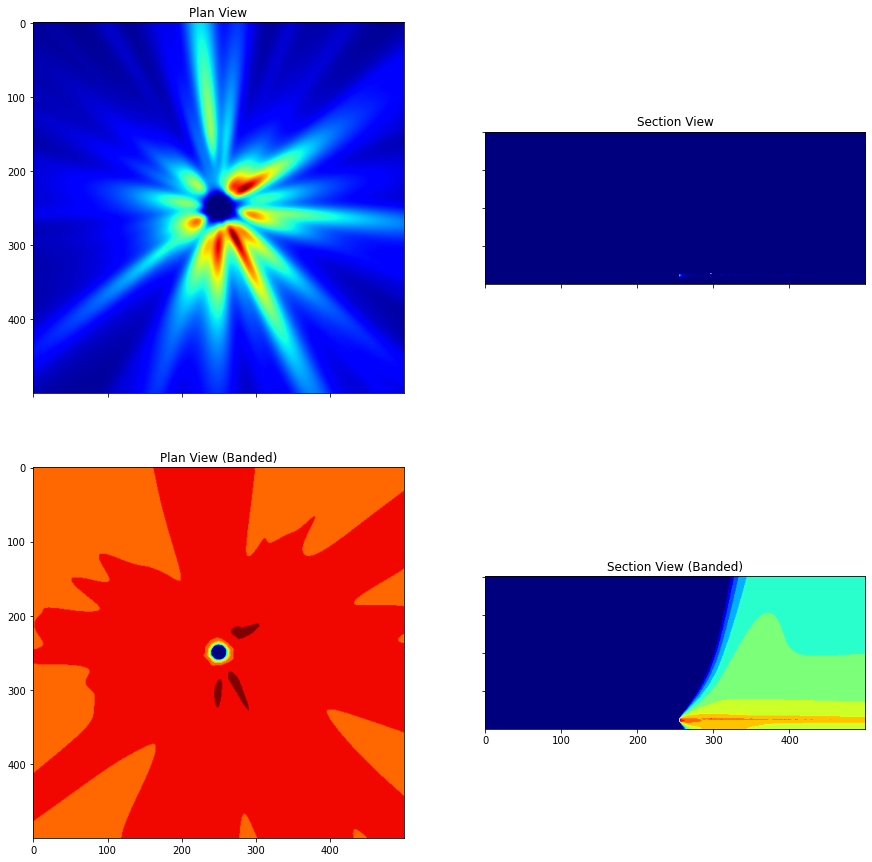

In [3]:
fig, axs = plt.subplots(2, 2)

fig.set_figheight(15)
fig.set_figwidth(15)

axs[0,0].set_title('Plan View')
axs[0,0].imshow(r_grid.reshape((domain.x_points, domain.y_points)), cmap='jet')
axs[0,1].set_title('Section View')
axs[0,1].imshow(h_grid.reshape((domain.z_points, domain.x_points)), cmap='jet')
axs[1,0].set_title('Plan View (Banded)')
axs[1,0].imshow(png_r_grid.reshape((domain.x_points, domain.y_points)), cmap='jet')
axs[1,1].set_title('Section View (Banded)')
axs[1,1].imshow(png_h_grid.reshape((domain.z_points, domain.x_points)), cmap='jet')

for ax in fig.get_axes():
    ax.label_outer()
